In [1]:
# first try to models and forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [190]:
#!pip3 install pandas --upgrade
!python3 -m pip install --upgrade sktime
!python3 -m pip install --upgrade statsmodels
!python3 -m pip install --upgrade tsfresh

Requirement already up-to-date: sktime in /Users/jerem/anaconda3/lib/python3.7/site-packages (0.4.2)
Requirement already up-to-date: statsmodels in /Users/jerem/anaconda3/lib/python3.7/site-packages (0.12.0)
Requirement already up-to-date: tsfresh in /Users/jerem/anaconda3/lib/python3.7/site-packages (0.17.0)


In [2]:
uber = pd.read_csv('../uber_data.csv', parse_dates = ['pickup_dt'])
uber = uber.dropna()
uber = uber.set_index('pickup_dt')

In [4]:
#on va commencer par manhattan pour le moment
man_uber = uber[uber['borough'] == 'Manhattan']

In [5]:
man_uber = man_uber[man_uber.index.month == 1]
man_uber = man_uber.dropna()
man_uber.tail()

,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
pickup_dt,,,,,,,,,,,,
2015-01-31 19:00:00,Manhattan,5162,6.0,10.0,25.0,-2.0,1019.0,0.0,0.005,0.06,7.0,N
2015-01-31 20:00:00,Manhattan,5482,11.0,10.0,26.0,-3.0,1018.9,0.0,0.005,0.06,7.0,N
2015-01-31 21:00:00,Manhattan,4801,9.0,10.0,26.0,0.0,1019.1,0.0,0.000,0.06,7.0,N
2015-01-31 22:00:00,Manhattan,4939,17.0,10.0,25.0,0.0,1019.8,0.0,0.000,0.06,7.0,N
2015-01-31 23:00:00,Manhattan,5295,7.0,10.0,24.0,1.0,1020.3,0.0,0.000,0.06,7.0,N


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [7]:
time = man_uber.index.to_numpy()
time

array(['2015-01-01T01:00:00.000000000', '2015-01-01T02:00:00.000000000',
       '2015-01-01T03:00:00.000000000', '2015-01-01T04:00:00.000000000',
       '2015-01-01T05:00:00.000000000', '2015-01-01T06:00:00.000000000',
       '2015-01-01T07:00:00.000000000', '2015-01-01T08:00:00.000000000',
       '2015-01-01T09:00:00.000000000', '2015-01-01T10:00:00.000000000',
       '2015-01-01T11:00:00.000000000', '2015-01-01T12:00:00.000000000',
       '2015-01-01T13:00:00.000000000', '2015-01-01T14:00:00.000000000',
       '2015-01-01T15:00:00.000000000', '2015-01-01T16:00:00.000000000',
       '2015-01-01T17:00:00.000000000', '2015-01-01T18:00:00.000000000',
       '2015-01-01T19:00:00.000000000', '2015-01-01T20:00:00.000000000',
       '2015-01-01T21:00:00.000000000', '2015-01-01T22:00:00.000000000',
       '2015-01-01T23:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-02T01:00:00.000000000', '2015-01-02T02:00:00.000000000',
       '2015-01-02T03:00:00.000000000', '2015-01-02

In [8]:
man_uber = man_uber['pickups']
man_uber = man_uber.to_numpy()
type(man_uber)

numpy.ndarray

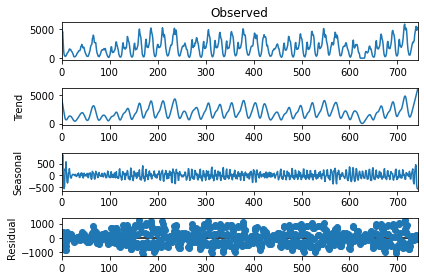

In [9]:
stl = STL(man_uber, period= 7)
result = stl.fit()
result.plot()
plt.show()

In [10]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

In [11]:
man_uber

array([5258, 4345, 4577, 3003, 1313,  672,  431,  329,  319,  420,  586,
        770,  931, 1012, 1143, 1317, 1582, 1485, 1520, 1444, 1235, 1153,
       1025,  808,  666,  330,  240,  241,  268,  362,  430,  589,  843,
        893, 1002, 1219, 1292, 1287, 1317, 1565, 2030, 2081, 2370, 2048,
       1806, 1818, 1918, 1685, 1263,  969,  763,  622,  384,  326,  310,
        312,  527,  717, 1069, 1309, 1865, 2182, 2303, 2465, 3375, 3550,
       3979, 3648, 2728, 2692, 2648, 2696, 1844, 1192,  825,  635,  339,
        317,  257,  422,  532,  810, 1125, 1315, 1442, 1437, 1402, 1536,
       1649, 1584, 1422, 1675, 1228,  999,  720,  472,  337,  181,  132,
        208,  449,  721, 1297, 1939, 1969, 1177,  962, 1069, 1036, 1157,
       1367, 1453, 1946, 2768, 2813, 2309, 2064, 1689, 1364,  750,  460,
        282,  188,  202,  343,  590, 1334, 2265, 2659, 2050, 1684, 1737,
       1580, 1594, 1853, 1851, 2768, 3742, 3438, 2979, 2812, 2427, 1689,
       1060,  601,  320,  204,  200,  331,  630, 14

In [14]:
y = pd.Series(data = man_uber)
y_train, y_test = temporal_train_test_split(y, test_size = 36)
print(y_train.shape[0])
print(y_test.shape[0])
print(type(y))

707
36
<class 'pandas.core.series.Series'>


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93fd193b10>)

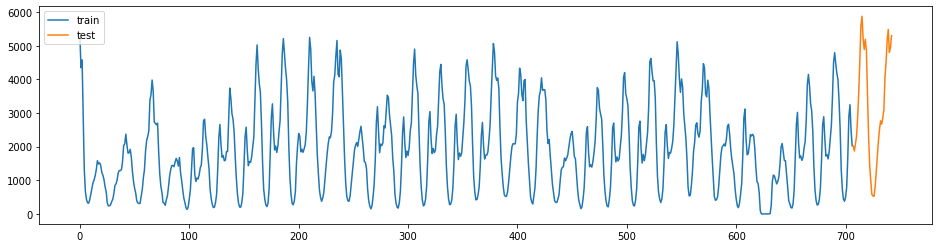

In [16]:
plot_ys(y_train, y_test, labels= ['train', 'test'])

In [17]:
#horizon de prediction
fh = np.arange(1,len(y_test)+1)

In [18]:
type(y_train)

pandas.core.series.Series

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93ff479c50>)

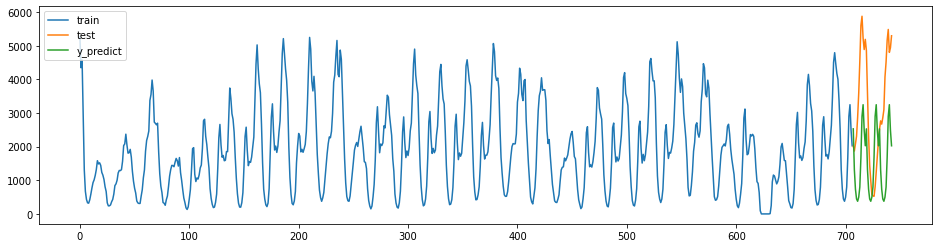

In [21]:
# avec sktime 

from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy='last',sp=12)

forecaster.fit(y_train)

y_predict_forecaster = forecaster.predict(fh)

plot_ys(y_train,y_test,y_predict_forecaster, labels = ['train', 'test','y_predict'])